In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('^HSI','2019-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26693/3467137344.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close
Date,,,,,
2018-01-02,30028.289062,30515.310547,30028.289062,30515.310547,30515.310547
2018-01-03,30658.730469,30724.320312,30456.759766,30560.949219,30560.949219
2018-01-04,30691.710938,30796.929688,30560.429688,30736.480469,30736.480469
2018-01-05,30893.859375,30911.009766,30638.529297,30814.640625,30814.640625
2018-01-08,30895.089844,30929.150391,30732.539062,30899.529297,30899.529297
...,...,...,...,...,...
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26693/1968958741.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])


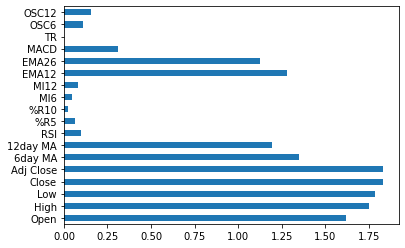

In [4]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [5]:
data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26693/244261082.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)


,Open,High,Low,Close,Adj Close,6day MA,12day MA,EMA12,EMA26,MACD,Prediction
Date,,,,,,,,,,,
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23113.381836,23494.919108,23394.847996,23829.572972,-434.724976,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23071.425130,23430.493327,23368.526730,23784.697920,-416.171190,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.080078,23349.301758,23354.993471,23747.354411,-392.360940,23086.539062
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062,23143.026693,23273.536621,23313.692793,23698.405126,-384.712333,23112.009766
2021-12-30,23130.449219,23248.259766,22990.240234,23112.009766,23112.009766,23166.473307,23203.322428,23282.664635,23654.968432,-372.303797,23397.669922


In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [7]:
# data['Prediction']=data['Close'].shift(-1)
# data.dropna(inplace=True)
# data_val=data[-100:]
# data=data[:-100]
# data_val.tail()

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(682, 1, 10) (682,) (171, 1, 10) (171,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26693/759405757.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(0.01)
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-11 05:30:34.147744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-11 05:30:34.147932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-11 05:30:34.540066: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-11 05:30:35.712287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:30:35.918120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:30:35.955078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:30:36.023121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:30:36.086876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 3s 40ms/step - loss: 748885568.0000 - val_loss: 623378752.0000
Epoch 2/500
 1/39 [..............................] - ETA: 0s - loss: 960224896.0000

2022-04-11 05:30:37.507209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:30:37.582943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:30:37.605121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 0s 10ms/step - loss: 748687360.0000 - val_loss: 623247872.0000
Epoch 3/500
39/39 [==============================] - 0s 10ms/step - loss: 747077376.0000 - val_loss: 622656832.0000
Epoch 4/500
39/39 [==============================] - 0s 10ms/step - loss: 742963712.0000 - val_loss: 618859648.0000
Epoch 5/500
39/39 [==============================] - 0s 10ms/step - loss: 735650432.0000 - val_loss: 608451136.0000
Epoch 6/500
39/39 [==============================] - 0s 10ms/step - loss: 725913216.0000 - val_loss: 597622720.0000
Epoch 7/500
39/39 [==============================] - 0s 10ms/step - loss: 715324992.0000 - val_loss: 587261312.0000
Epoch 8/500
39/39 [==============================] - 0s 10ms/step - loss: 703823168.0000 - val_loss: 576281920.0000
Epoch 9/500
39/39 [==============================] - 0s 10ms/step - loss: 691377792.0000 - val_loss: 564492288.0000
Epoch 10/500
39/39 [==============================] - 0s 10ms/step - loss: 678010560

39/39 [==============================] - 0s 9ms/step - loss: 5216219.5000 - val_loss: 3062357.7500
Epoch 74/500
39/39 [==============================] - 0s 10ms/step - loss: 5042523.0000 - val_loss: 3349072.7500
Epoch 75/500
39/39 [==============================] - 0s 10ms/step - loss: 4902276.0000 - val_loss: 3622273.5000
Epoch 76/500
39/39 [==============================] - 0s 9ms/step - loss: 4789505.0000 - val_loss: 3879644.0000
Epoch 77/500
39/39 [==============================] - 0s 9ms/step - loss: 4699154.0000 - val_loss: 4119673.5000
Epoch 78/500
39/39 [==============================] - 0s 10ms/step - loss: 4627009.5000 - val_loss: 4341516.0000
Epoch 79/500
39/39 [==============================] - 0s 9ms/step - loss: 4569574.0000 - val_loss: 4544888.5000
Epoch 80/500
39/39 [==============================] - 0s 9ms/step - loss: 4523963.5000 - val_loss: 4729950.0000
Epoch 81/500
39/39 [==============================] - 0s 9ms/step - loss: 4487814.5000 - val_loss: 4897180.5000
Ep

Epoch 147/500
39/39 [==============================] - 0s 9ms/step - loss: 226669.3438 - val_loss: 58317.1250
Epoch 148/500
39/39 [==============================] - 0s 9ms/step - loss: 220703.7344 - val_loss: 58296.5547
Epoch 149/500
39/39 [==============================] - 0s 9ms/step - loss: 215067.0156 - val_loss: 58366.5039
Epoch 150/500
39/39 [==============================] - 0s 9ms/step - loss: 209745.7344 - val_loss: 58514.1719
Epoch 151/500
39/39 [==============================] - 0s 9ms/step - loss: 204725.8438 - val_loss: 58725.4922
Epoch 152/500
39/39 [==============================] - 0s 9ms/step - loss: 199993.2812 - val_loss: 58986.8359
Epoch 153/500
39/39 [==============================] - 0s 9ms/step - loss: 195534.5000 - val_loss: 59284.3984
Epoch 154/500
39/39 [==============================] - 0s 9ms/step - loss: 191334.9844 - val_loss: 59605.1406
Epoch 155/500
39/39 [==============================] - 0s 9ms/step - loss: 187381.7188 - val_loss: 59936.7266
Epoch 156/

39/39 [==============================] - 0s 9ms/step - loss: 127409.8125 - val_loss: 106549.8828
Epoch 222/500
39/39 [==============================] - 0s 10ms/step - loss: 128844.5391 - val_loss: 69811.2500
Epoch 223/500
39/39 [==============================] - 0s 9ms/step - loss: 174545.2031 - val_loss: 226614.2031
Epoch 224/500
39/39 [==============================] - 0s 10ms/step - loss: 183651.0625 - val_loss: 120686.6719
Epoch 225/500
39/39 [==============================] - 0s 9ms/step - loss: 269044.5625 - val_loss: 231500.6250
Epoch 226/500
39/39 [==============================] - 0s 10ms/step - loss: 182570.8281 - val_loss: 68098.8438
Epoch 227/500
39/39 [==============================] - 0s 10ms/step - loss: 170388.9062 - val_loss: 65667.4766
Epoch 228/500
39/39 [==============================] - 0s 9ms/step - loss: 130767.7812 - val_loss: 70561.3125
Epoch 229/500
39/39 [==============================] - 0s 10ms/step - loss: 131140.2344 - val_loss: 74121.7656
Epoch 230/500
3

39/39 [==============================] - 0s 9ms/step - loss: 140999.3750 - val_loss: 90700.8047
Epoch 296/500
39/39 [==============================] - 0s 9ms/step - loss: 127307.9297 - val_loss: 65627.2656
Epoch 297/500
39/39 [==============================] - 0s 9ms/step - loss: 142730.3594 - val_loss: 90005.3125
Epoch 298/500
39/39 [==============================] - 0s 9ms/step - loss: 127600.8984 - val_loss: 65518.4805
Epoch 299/500
39/39 [==============================] - 0s 10ms/step - loss: 142008.9531 - val_loss: 87742.3750
Epoch 300/500
39/39 [==============================] - 0s 10ms/step - loss: 126420.8203 - val_loss: 65080.7188
Epoch 301/500
39/39 [==============================] - 0s 9ms/step - loss: 139449.2344 - val_loss: 85166.0625
Epoch 302/500
39/39 [==============================] - 0s 10ms/step - loss: 124511.3984 - val_loss: 64590.5820
Epoch 303/500
39/39 [==============================] - 0s 10ms/step - loss: 136391.2031 - val_loss: 83144.6172
Epoch 304/500
39/39 

39/39 [==============================] - 0s 10ms/step - loss: 133987.9688 - val_loss: 84206.3984
Epoch 370/500
39/39 [==============================] - 0s 10ms/step - loss: 122890.3906 - val_loss: 65979.0078
Epoch 371/500
39/39 [==============================] - 0s 10ms/step - loss: 133810.8438 - val_loss: 84030.6797
Epoch 372/500
39/39 [==============================] - 0s 9ms/step - loss: 122763.8281 - val_loss: 65973.4609
Epoch 373/500
39/39 [==============================] - 0s 11ms/step - loss: 133536.8438 - val_loss: 83841.5938
Epoch 374/500
39/39 [==============================] - 0s 11ms/step - loss: 122599.3125 - val_loss: 65964.2812
Epoch 375/500
39/39 [==============================] - 0s 11ms/step - loss: 133234.4688 - val_loss: 83684.6719
Epoch 376/500
39/39 [==============================] - 0s 11ms/step - loss: 122441.8828 - val_loss: 65961.9609
Epoch 377/500
39/39 [==============================] - 0s 10ms/step - loss: 132968.6406 - val_loss: 83593.1875
Epoch 378/500
39

39/39 [==============================] - 0s 9ms/step - loss: 130930.5234 - val_loss: 83721.4141
Epoch 444/500
39/39 [==============================] - 0s 9ms/step - loss: 122249.5781 - val_loss: 66777.1875
Epoch 445/500
39/39 [==============================] - 0s 9ms/step - loss: 130835.9531 - val_loss: 83704.0234
Epoch 446/500
39/39 [==============================] - 0s 9ms/step - loss: 122227.7109 - val_loss: 66791.2969
Epoch 447/500
39/39 [==============================] - 0s 9ms/step - loss: 130743.1797 - val_loss: 83694.0312
Epoch 448/500
39/39 [==============================] - 0s 9ms/step - loss: 122209.8281 - val_loss: 66806.5781
Epoch 449/500
39/39 [==============================] - 0s 9ms/step - loss: 130658.4062 - val_loss: 83690.6172
Epoch 450/500
39/39 [==============================] - 0s 9ms/step - loss: 122199.5703 - val_loss: 66824.0859
Epoch 451/500
39/39 [==============================] - 0s 9ms/step - loss: 130584.1484 - val_loss: 83696.2656
Epoch 452/500
39/39 [===

2022-04-11 05:33:43.854283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:33:43.929622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 05:33:43.970803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


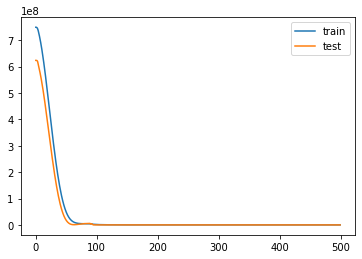

In [11]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

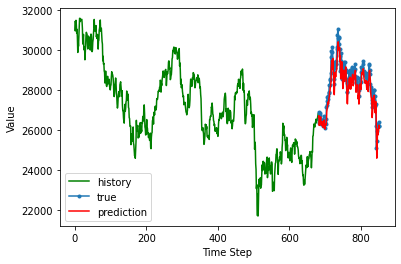

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

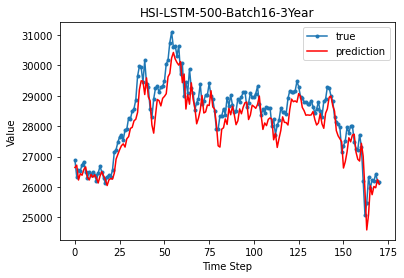

In [13]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-500-Batch16-3Year')
plt.legend()
plt.show();

In [14]:
r2_score(y_test,y_pred)

0.818834253965183

In [15]:
mean_absolute_percentage_error(y_test,y_pred)

0.014592429153220877

In [16]:
mean_squared_error(y_test,y_pred,squared=False)

502.8177023890229

In [17]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26693/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


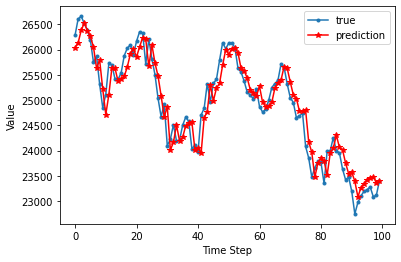

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.9036881350869979

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.01029205119321469

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

311.75245409228256